In [ ]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from metrics import Metric
from rank_fuser import RankFuser
from statistics_computation import compute_statistics

log_citations = Metric.get_metric("log_citations")
negative_log_years_old = Metric.get_metric("negative_log_years_old")

In [ ]:
rank_fuser = RankFuser(config={"log_citations": 1.0, "negative_log_years_old": 4.0})

In [3]:
FILE = "experiments/query_expansions/results/bge_title_search_results.jsonl"

# truncate the data to top k=200
data = []
with open(FILE, "r") as f:
    for line in f:
        row_data = json.loads(line)
        row_data["results"] = row_data["results"][:200]
        data.append(row_data)
    # data = [json.loads(line) for line in f]

print(len(data))

14735


In [4]:
reranked = rank_fuser.rerank(data)
print(len(reranked))

Reranking results: 100%|██████████| 14735/14735 [01:37<00:00, 151.47it/s]

14735


In [5]:
stats = compute_statistics(reranked)
print(stats.keys())

Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2744.75it/s]

dict_keys(['hitrate', 'iou', 'recall'])


In [16]:
np.arange(3, -3.5, step=-0.5)

array([ 3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5, -2. ,
       -2.5, -3. ])

In [23]:
import numpy as np

diffs = np.arange(3.0, -3.1, step=-0.5)
hitrate_matrix = np.zeros((len(diffs), 200))
recall_matrix = np.zeros((len(diffs), 200))
iou_matrix = np.zeros((len(diffs), 200))

for row, diff in enumerate(diffs):
    config = {"log_citations": 4.0 + diff.item(), "negative_log_years_old": 4.0}
    print(f"Preparing rank fusion with: {config}")
    rank_fuser = RankFuser(config=config)
    stats = compute_statistics(rank_fuser.rerank(data))
    hitrate_matrix[row] = stats["hitrate"]
    recall_matrix[row] = stats["recall"]
    iou_matrix[row] = stats["iou"]

Preparing rank fusion with: {'log_citations': 7.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2851.75it/s]


Preparing rank fusion with: {'log_citations': 6.5, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2914.43it/s]


Preparing rank fusion with: {'log_citations': 6.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2719.07it/s]


Preparing rank fusion with: {'log_citations': 5.5, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2891.48it/s]


Preparing rank fusion with: {'log_citations': 5.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2931.10it/s]


Preparing rank fusion with: {'log_citations': 4.5, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2769.23it/s]


Preparing rank fusion with: {'log_citations': 4.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:04<00:00, 2952.78it/s]


Preparing rank fusion with: {'log_citations': 3.5, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:04<00:00, 2956.99it/s]


Preparing rank fusion with: {'log_citations': 3.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2869.77it/s]


Preparing rank fusion with: {'log_citations': 2.5, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2674.16it/s]


Preparing rank fusion with: {'log_citations': 2.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2895.15it/s]


Preparing rank fusion with: {'log_citations': 1.5, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2871.17it/s]


Preparing rank fusion with: {'log_citations': 1.0, 'negative_log_years_old': 4.0}


Computing statistics: 100%|██████████| 14735/14735 [00:05<00:00, 2889.84it/s]


In [ ]:
original_stats = compute_statistics(data)
print(original_stats.keys())

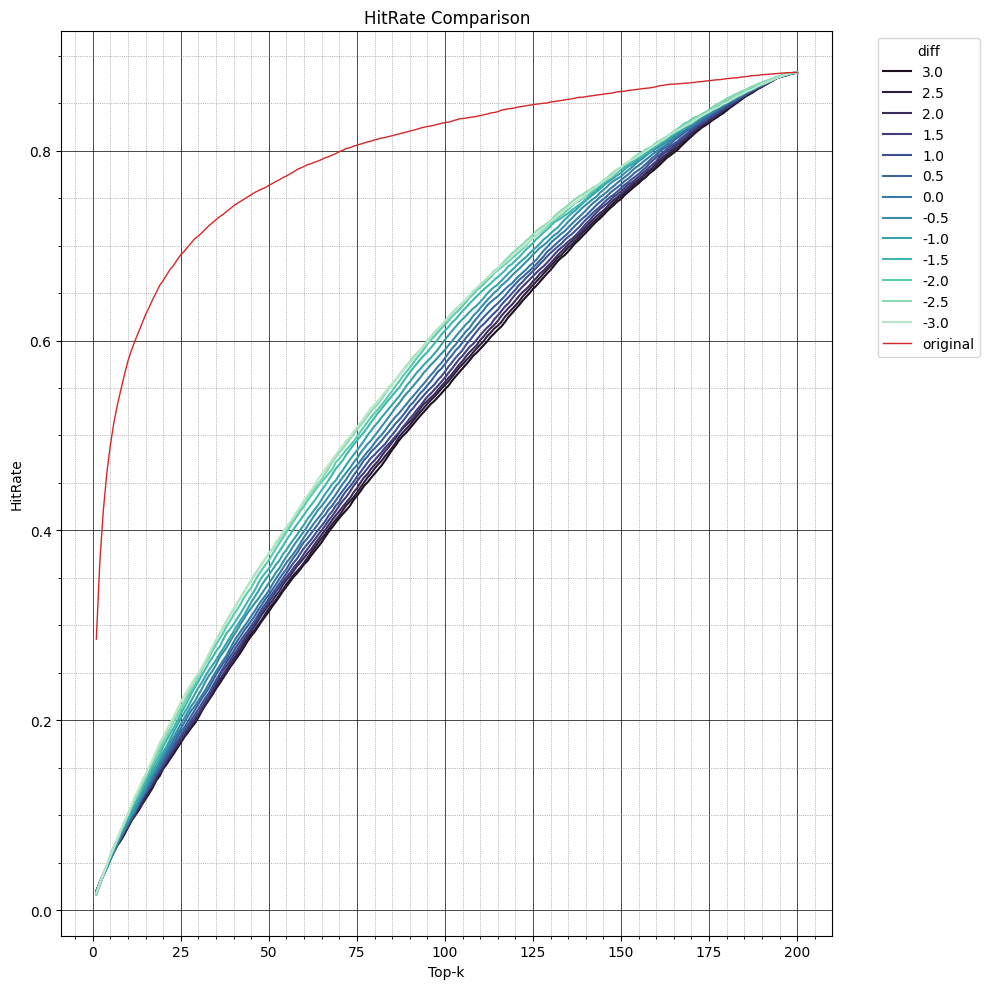

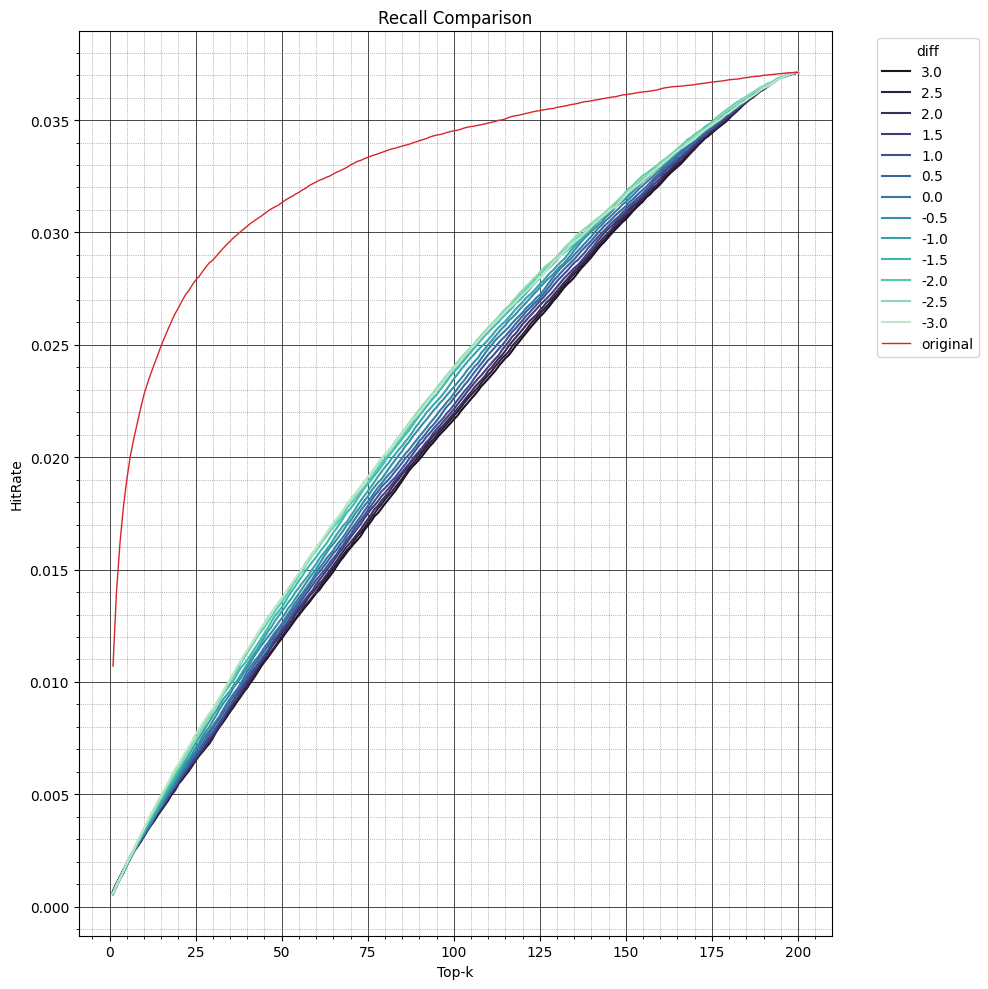

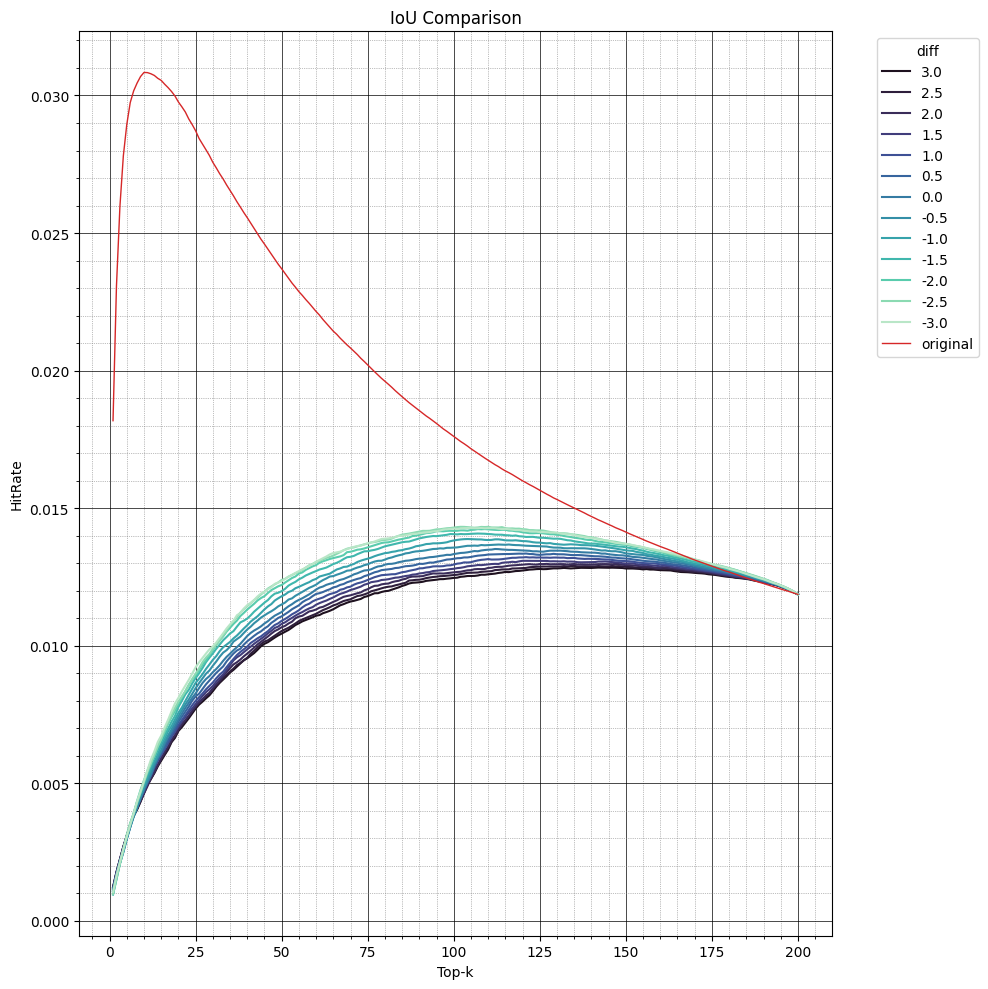

In [58]:
# build DataFrame: rows=diffs, cols=1..200
def plot_stat_comparison(original, reranks, title=""):
    # Original stats is one array so its length is on shape index 0; reranks' length is on shape index 1
    assert original.shape[0] == reranks.shape[1]
    df = pd.DataFrame(reranks, index=labels, columns=np.arange(1, reranks.shape[1] + 1))

    df_long = df.reset_index().melt(id_vars="index", var_name="k", value_name="hitrate").rename(columns={"index": "diff"})
    plt.figure(figsize=(10, 10))

    # Plot original and reranked data
    ax = sns.lineplot(data=df_long, x="k", y="hitrate", hue="diff", legend="full", palette="mako")
    ax.plot(np.arange(1, 201), original, label="original", linewidth=1)

    handles, labels_legend = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels_legend, title="diff", bbox_to_anchor=(1.05, 1), loc=2)

    plt.xlabel("Top-k")
    plt.ylabel("HitRate")
    plt.minorticks_on()
    plt.grid(which="major", linestyle="-", linewidth="0.5", color="black")
    plt.grid(which="minor", linestyle=":", linewidth="0.5", color="gray")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_stat_comparison(original_stats['hitrate'], hitrate_matrix, title="HitRate Comparison")
plot_stat_comparison(original_stats['recall'], recall_matrix, title="Recall Comparison")
plot_stat_comparison(original_stats['iou'], iou_matrix, title="IoU Comparison")

In [64]:
recency_reranker = RankFuser(config={"negative_log_years_old": -1.0})
recency_stats = compute_statistics(recency_reranker.rerank(data))

Computing statistics: 100%|██████████| 14735/14735 [00:04<00:00, 3117.51it/s]


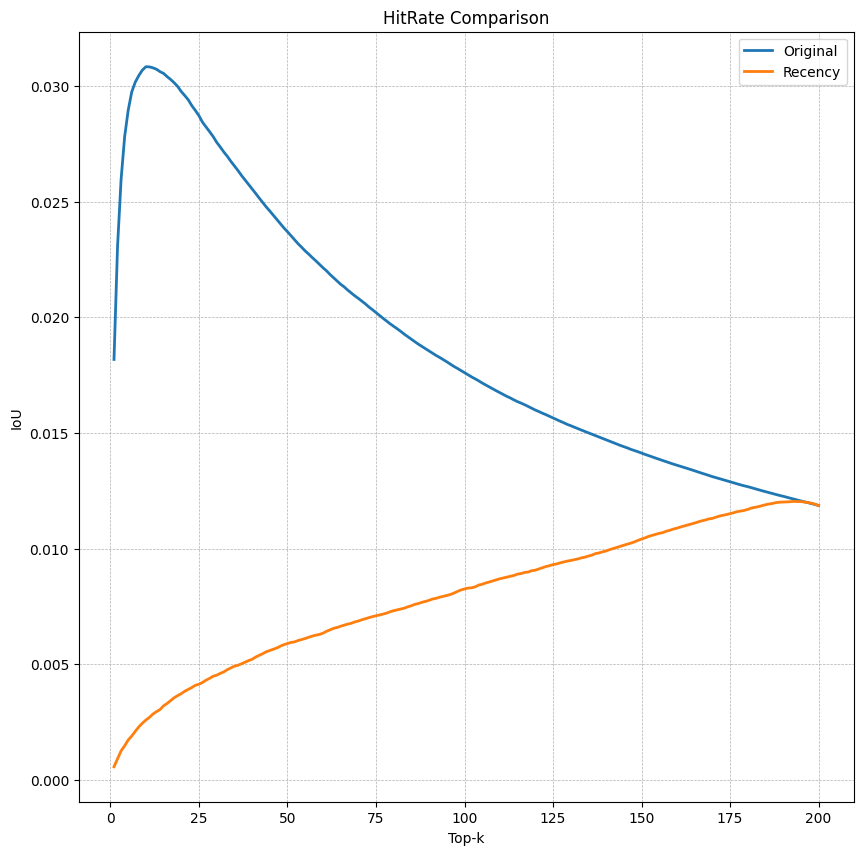

In [67]:
x = np.arange(1, 201)  # Top-k 1..200
plt.figure(figsize=(10, 10))
plt.plot(x, original_stats['iou'], label="Original", linewidth=2)
plt.plot(x, recency_stats['iou'], label="Recency", linewidth=2)
plt.xlabel("Top-k")
plt.ylabel("IoU")
plt.legend()
plt.grid(True, which="major", linestyle="--", linewidth=0.5)
plt.title("HitRate Comparison")
plt.show()

In [62]:
plot_stat_comparison(original_stats['hitrate'], np.array(recency_stats['hitrate']).reshape(1, -1), title="HitRate Comparison")
plot_stat_comparison(original_stats['recall'], np.array(recency_stats['recall']).reshape(1, -1), title="Recall Comparison")
plot_stat_comparison(original_stats['iou'], np.array(recency_stats['iou']).reshape(1, -1), title="IoU Comparison")

ValueError: Shape of passed values is (1, 200), indices imply (13, 200)